In [1]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

pd.options.display.max_columns = 100
random_state = 123

In [2]:
pd.options.display.max_columns = 100
random_state = 123

## データ修正

In [4]:
#データ読み込み
train = pd.read_csv("data/train_df.csv")
train2 = pd.read_csv("labeling_data/lgb_2nd.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [7]:
train = train2

In [8]:
#カテゴリと考えられる変数を変更
ids = ['id', 'personal_id_1', 'personal_id_2',]
#cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3']
# cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3', 'blood_oxy'] old_cats
cats = ['facility_id', 'icu_5', 'icu_id']#best
dis_name = ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma'] 
for c in ids:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

for c in cats:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)
    
for c in dis_name:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

## 追加

In [9]:
data = [train, test]
for d in data:
    d['sum_glasgow'] = np.sum(d[['glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_4']], axis=1)

In [10]:
# 数値データ
y_train=train[['target_label']]
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
print('-'*100)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)

数値データ
['age', 'bmi', 'situation_1', 'situation_2', 'height', 'weight', 'icu_4', 'icu_6', 'icu_7', 'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'sum_glasgow']
----------------------------------------------------------------------------------------------------
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma', 'body_system_1'

In [11]:
"""
エンコーディングの方針
nunique が比較的少ない変数はLabel Encoding
nunique が多い変数はCount EncodingとTarget Encodingの併用
"""

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in col_cat:
    nunq = x_train[c].nunique()
    if nunq>48:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)
        
body_systems = ['body_system_1', 'body_system_2']
for r in body_systems:
    low_cat_cols.remove(r)
        
print('-'*20, 'unique_low', '-'*20)
print(low_cat_cols)
print('-'*20, 'unique_high', '-'*20)
print(high_cat_cols)

print('-'*20, 'body_systems', '-'*20)
print(body_systems)

-------------------- unique_low --------------------
['ethnicity', 'gender', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']
-------------------- unique_high --------------------
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'icu_id']
-------------------- body_systems --------------------
['body_system_1', 'body_system_2']


In [12]:
#少ない要素は確認してみる
for c in low_cat_cols:
    print(f"{c}:\t{x_train[c].unique()}")

ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_5:	[302.0 nan 304.0 123.0 114.0 305.0 301.0 122.0 119.0 308.0 113.0 118.0
 124.0 104.0 303.0 112.0 109.0 117.0 209.0 214.0 121.0 202.0 212.0 110.0
 101.0 116.0 217.0 102.0 115.0 203.0 105.0 103.0 108.0 307.0 213.0 120.0
 106.0 216.0 306.0 107.0 207.0 215.0 218.0 219.0 208.0]
aids:	[0.0 nan 1.0]
cirrhosis:	[0.0 1.0 nan]
diabetes:	[1.0 0.0 nan]
hepatic_issue:	[0.0 1.0 nan]
immunosuppression:	[0.0 1.0 nan]
leukemia:	[0.0 1.0 nan]
lymphoma:	[0.0 nan 1.0]
carcinoma:	[0.0 1.0 nan]


In [13]:
#nunique が少ない変数はLabel Encoding
#body_system1,2は同様のカラムだと考えohe

dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(x_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    x_train[col] = x_train[col].map(map_label)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    dict_low_cat[col]['map_label'] = map_label
    dict_low_cat[col]['num_label'] = len(list_label)

print('Done')

ethnicity
gender
icu_1
icu_2
icu_3
icu_5
aids
cirrhosis
diabetes
hepatic_issue
immunosuppression
leukemia
lymphoma
carcinoma
Done


In [14]:
# nunique が多い変数はCount EncodingとTarget Encodingの併用
# クロスバリデーション内で行う

# Count Encoding用
ids = ['id', 'personal_id_1', 'personal_id_2']
for i in ids:
    high_cat_cols.remove(i)
    
dict_high_cat = {}
for col in high_cat_cols :
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    
    map_count = x_train[col].value_counts().to_dict()
    x_train['CE_' + col] = x_train[col].map(map_count)
    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_count'] = map_count
    # dict_high_cat[col]['num_label'] = len(list_label)
    
    
print('Done')

facility_id
icu_id
Done


In [15]:
# 数値データは標準化
dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    x_train[col] = x_train[col].fillna(value_fillna)
    # 正規化
    value_min = x_train[col].min()
    value_max = x_train[col].max()
    value_mean = x_train[col].mean()
    value_std = x_train[col].std()
    #train[col] = (train[col] - value_min) / (value_max - value_min)
    x_train[col] = (x_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_mean    
    dict_num[col]['std'] = value_std    
    
print('Done')

age
bmi
situation_1
situation_2
height
weight
icu_4
icu_6
icu_7
icu_8
glasgow_coma_scale_1
glasgow_coma_scale_2
glasgow_coma_scale_3
glasgow_coma_scale_4
heart_rate
blood_oxy
arterial_pressure
respiratory_rate
temp
blood_pressure_1
blood_pressure_2
blood_pressure_3
blood_pressure_4
v1_heartrate_max
v2
v3
v4
v5
v6
v7
v8
v9
v10
v11
v12
v13
v14
v15
v16
w1
w2
w3
w4
w5
w6
w7
w8
w9
w10
w11
w12
w13
w14
w15
w16
w17
w18
x1
x2
x3
x4
x5
x6
sum_glasgow
Done


In [16]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        value_mean = dict_num[col]['mean']
        value_std = dict_num[col]['std']
        
        # output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_low_cat[col]['map_label']#辞書からlabel_encordの辞書を取り出す
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_count = dict_high_cat[col]['map_count']#辞書からcount_encodの辞書を取り出す
        output_x['CE_' + col] = output_x[col].map(map_count)
        
        
    return output_x

x_test = transform_data(test)

In [17]:
#body_sytemsとhigh_cat_cols（target_encord)以外修正後
#データを統合しbody_sytemsをone_hotencoding

# OHEのため全データ合算
concat_df = pd.concat([x_train, x_test], sort=False, ignore_index = True)

#病名のみのdf
train_body=concat_df[['body_system_1','body_system_2']]
#被っているものはbody_system_2をNanに
train_body['body_system_2'] = train_body['body_system_2'].where(
    train_body['body_system_1'] != train_body['body_system_2'])
#Nanはunknoun
train_body.fillna('unknown', inplace=True)

train_body['body_system_2'] = train_body['body_system_2'].replace('Undefined diagnoses', 'Undefined Diagnoses')
print(train_body.shape, concat_df.shape)

print(train_body['body_system_1'].unique())
print(train_body['body_system_2'].unique())
# ohe実行
ohe_body = pd.get_dummies(train_body.stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()

(73468, 2) (73468, 87)
['Cardiovascular' 'unknown' 'Gastrointestinal' 'Metabolic' 'Genitourinary'
 'Neurological' 'Trauma' 'Sepsis' 'Respiratory' 'Musculoskeletal/Skin'
 'Gynecological' 'Hematological']
['unknown' 'Renal/Genitourinary' 'Neurologic' 'Undefined Diagnoses'
 'Cardiovascular' 'Haematologic']


In [18]:
ohe_concat_df = pd.concat([concat_df, ohe_body], axis=1)#元の全体のDFに病歴のOHEをつなげる
ohe_concat_df = ohe_concat_df.drop(['body_system_1','body_system_2','ohe_unknown'], axis=1)
# 学習とテストに分解
x_train = ohe_concat_df[:len(x_train)]
x_test = ohe_concat_df[len(x_train):].reset_index(drop=True)

# idを別のdfに、
id_train = x_train[['id']]
x_train = x_train.drop(ids, axis=1)

id_test = x_test[id_train.columns]
x_test = x_test.drop(ids, axis=1)

print('学習用データ: {},   学習ラベル：{},  テストデータ：{}、学習IDデータ:{}, テストIDデータ:{}'.format(
    x_train.shape, y_train.shape, x_test.shape, id_train.shape, id_test.shape))
# print('taget_encord用学習データ：{},  target_encord用テストデータ：{}'.format(
#       te_base_train.shape, te_base_test.shape))

print('陽性ラベルの割合: {}'.format(
    y_train.value_counts()[1]  / len(train)))

学習用データ: (60628, 97),   学習ラベル：(60628, 1),  テストデータ：(12840, 97)、学習IDデータ:(60628, 1), テストIDデータ:(12840, 1)
陽性ラベルの割合: 0.07625189681335356


In [19]:
#初期データ
display(train)
display(test)

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label,sum_glasgow
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,175.30,76.0,698,Floor,admit,MICU,25.801389,302.0,109.09,0,0.0,3.0,6.0,0.0,3.0,100.0,0.0,50.0,33.0,NaN,59.0,46.0,59.0,46.0,96.0,91.0,84.0,53.0,84.0,53.0,16.0,14.0,100.0,97.0,124.0,67.0,124.0,67.0,37.10,36.80,46.0,46.0,46.0,46.0,96.0,96.0,53.0,53.0,53.0,53.0,16.0,16.0,100.0,100.0,75.0,67.0,75.0,67.0,243.0,76.0,3.5,3.5,0.25,0.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0.0,12.0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,183.00,96.0,657,Floor,admit,CCU-CTICU,3.639583,NaN,0.19,0,0.0,1.0,1.0,0.0,1.0,117.0,0.0,145.0,4.0,36.72,73.0,48.0,73.0,48.0,111.0,62.0,100.0,59.0,100.0,59.0,30.0,0.0,97.0,87.0,178.0,99.0,178.0,99.0,37.38,36.72,NaN,NaN,NaN,NaN,83.0,80.0,NaN,NaN,NaN,NaN,17.0,8.0,94.0,93.0,NaN,NaN,NaN,NaN,158.0,109.0,4.2,4.2,0.42,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3.0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,166.00,50.0,482,Accident & Emergency,admit,MICU,0.059028,304.0,307.01,0,0.0,4.0,6.0,0.0,5.0,53.0,0.0,50.0,6.0,36.10,65.0,39.0,65.0,39.0,71.0,55.0,73.0,50.0,73.0,50.0,18.0,11.0,100.0,100.0,122.0,69.0,122.0,69.0,37.00,36.10,65.0,65.0,65.0,65.0,62.0,59.0,73.0,73.0,73.0,73.0,18.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,62.0,4.2,4.1,0.07,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0.0,15.0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,182.90,77.1,855,Accident & Emergency,admit,CCU-CTICU,0.014583,123.0,702.01,0,0.0,4.0,6.0,0.0,5.0,102.0,0.0,127.0,4.0,37.00,87.0,69.0,87.0,69.0,99.0,75.0,114.0,86.0,114.0,86.0,21.0,15.0,100.0,96.0,153.0,123.0,153.0,123.0,37.10,36.60,80.0,73.0,80.0,73.0,99.0,96.0,97.0,86.0,97.0,86.0,18.0,17.0,98.0,97.0,124.0,123.0,124.0,123.0,373.0,46.0,4.2,3.2,0.01,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0.0,15.0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,160.02,51.7,136,Accident & Emergency,admit,Med-Surg ICU,0.004861,304.0,308.01,0,0.0,4.0,6.0,0.0,5.0,90.0,0.0,68.0,28.0,36.80,87.0,87.0,87.0,87.0,90.0,90.0,105.0,105.0,105.0,105.0,14.0,11.0,97.0,92.0,147.0,147.0,147.0,147.0,36.80,36.80,100.0,56.0,100.0,56.0,67.0,61.0,104.0,68.0,104.0,68.0,28.0,24.0,94.0,90.0,142.0,114.0,142.0,114.0,NaN,NaN,NaN,NaN,0.08,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60623,NaN,NaN,NaN,NaN,57.0,49.170233,0,0.0,Caucasian,F,162.60,130.0,NaN,Accident & Emergency,admit,Cardiac ICU,0.063889,NaN,704.01,0,0.0,4.0,6.0,0.0,5.0,63.0,0.0,55.0,4.0,37.10,53.0,52.0,53.0,52.0,77.0,67.0,76.0,64.0,76.0,64.0,19.0,14.0,98.0,97.0,112.0,90.0,112.0,90.0,37.10,37.10,53.0,53.0,53.0,53.0,77.0,77.0,76.0,76.0,76.0,76.0,19.0,19.0,97.0,97.0,112.0,112.0,112.0,112.0,125.0,119.0,3.8,3.7,0.02,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Metabolic,Metabolic,0.0,15.0
60624,NaN,NaN,NaN,NaN,39.0,23.147277,0,0.0,Caucasian,F,163.00,61.5,NaN,Accident & Emergency,admit,CCU-CTICU,0.155556,NaN,301.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,62.0,8.0,36.33,98.0,52.0,98.0,52.0,111.0,84.0,106.0,62.0,106.0,62

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,sum_glasgow
0,51359,12058,66446,83,37.0,NaN,0,0.0,Caucasian,M,182.9,NaN,95,Floor,readmit,Med-Surg ICU,0.902778,113.0,501.02,0,0.0,4.0,6.0,0.0,5.0,123.0,0.0,76.0,4.0,37.00,74.0,56.0,74.0,56.0,120.0,103.0,93.0,74.0,93.0,74.0,19.0,6.0,99.0,90.0,127.0,106.0,127.0,106.0,37.30,36.90,65.0,60.0,65.0,60.0,112.0,104.0,84.0,84.0,84.0,84.0,19.0,16.0,99.0,92.0,115.0,111.0,115.0,111.0,160.0,122.0,3.5,3.5,-1.00,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,15.0
1,51360,92348,32311,185,60.0,32.961764,1,0.0,Caucasian,M,185.4,113.30,679,Operating Room / Recovery,admit,Neuro ICU,0.406944,NaN,0.25,0,0.0,3.0,6.0,0.0,4.0,60.0,0.0,151.0,5.0,37.20,85.0,81.0,85.0,81.0,83.0,68.0,132.0,107.0,132.0,107.0,14.0,11.0,97.0,92.0,191.0,146.0,191.0,146.0,37.40,37.20,85.0,85.0,85.0,85.0,68.0,68.0,132.0,132.0,132.0,132.0,11.0,11.0,97.0,97.0,191.0,191.0,191.0,191.0,259.0,184.0,4.4,4.4,0.05,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,13.0
2,51361,68371,20639,157,70.0,19.295957,0,1.0,Caucasian,M,177.8,61.00,697,Floor,admit,SICU,0.977083,303.0,211.09,0,0.0,3.0,5.0,0.0,1.0,106.0,0.0,58.0,39.0,36.50,78.0,51.0,78.0,51.0,87.0,69.0,98.0,73.0,98.0,73.0,20.0,14.0,100.0,100.0,127.0,103.0,127.0,103.0,36.60,36.50,78.0,78.0,78.0,78.0,87.0,87.0,98.0,98.0,98.0,98.0,14.0,14.0,100.0,100.0,127.0,127.0,127.0,127.0,113.0,93.0,4.1,4.1,0.13,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,9.0
3,51362,19544,116026,60,54.0,27.900747,0,1.0,Caucasian,M,180.3,90.70,538,Accident & Emergency,admit,Med-Surg ICU,0.172917,122.0,703.03,0,0.0,4.0,6.0,0.0,4.0,118.0,0.0,189.0,53.0,NaN,144.0,73.0,144.0,73.0,118.0,59.0,184.0,81.0,181.0,81.0,53.0,0.0,100.0,94.0,232.0,101.0,232.0,101.0,35.10,34.50,112.0,95.0,112.0,95.0,102.0,88.0,136.0,116.0,136.0,116.0,29.0,15.0,98.0,97.0,183.0,156.0,183.0,156.0,101.0,101.0,3.7,3.7,0.03,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,14.0
4,51363,85588,102404,196,85.0,39.414062,0,1.0,Caucasian,F,160.0,100.90,809,Accident & Emergency,admit,CSICU,0.031944,117.0,106.01,0,0.0,4.0,6.0,0.0,5.0,165.0,0.0,63.0,37.0,36.70,84.0,52.0,84.0,52.0,163.0,114.0,91.0,63.0,91.0,63.0,32.0,18.0,98.0,89.0,119.0,90.0,119.0,90.0,37.10,36.70,66.0,66.0,66.0,66.0,160.0,144.0,77.0,77.0,77.0,77.0,27.0,27.0,96.0,96.0,119.0,119.0,119.0,119.0,110.0,110.0,3.9,3.9,0.15,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,64194,79880,56511,19,39.0,23.147277,0,0.0,Caucasian,F,163.0,61.50,657,Accident & Emergency,admit,CCU-CTICU,0.155556,304.0,301.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,62.0,8.0,36.33,98.0,52.0,98.0,52.0,111.0,84.0,106.0,62.0,106.0,62.0,21.0,10.0,97.0,88.0,159.0,85.0,159.0,85.0,37.38,36.33,63.0,54.0,63.0,54.0,103.0,100.0,75.0,68.0,75.0,68.0,17.0,15.0,94.0,90.0,120.0,109.0,120.0,109.0,117.0,89.0,6.4,5.5,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,15.0
12836,64195,97405,32055,136,79.0,27.759515,0,0.0,Caucasian,M,175.5,85.50,374,Accident & Emergency,admit,Med-Surg ICU,0.195139,112.0,107.01,0,0.0,4.0,6.0,0.0,5.0,103.0,0.0,46.0,13.0,36.30,77.0,43.

In [20]:
# 処理後
display(x_train)
display(x_test)

,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,sum_glasgow,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,51,0.470442,-0.350090,-0.4827,1.496902,2,1,0.353541,-0.202549,698,1,0,4,10.195277,37,-0.958632,-0.509807,-0.167208,-0.404470,0.415078,-0.095943,-0.596473,0.061541,-0.40967,-0.880434,0.510495,-4.634794,-1.471486,-0.328340,-1.318881,-0.280109,-0.280637,1.229265,-0.964250,-0.764635,-0.782049,-0.645723,-1.166409,0.245212,0.184046,0.599524,-0.925298,-1.456925,-0.757391,-1.288413,0.126135,0.248973,-1.146986,-0.730204,-0.871995,-0.530322,0.267034,0.625034,-1.209381,-0.893798,-0.874574,-0.630496,-0.620241,-0.042250,0.309311,0.434988,-1.434449,-1.324479,-1.055653,-0.994568,0.856075,-0.664261,-0.198955,-0.009586,0.765213,0.171629,0,0,1,0,0,0,0,0,-0.203142,59,59.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19,0.230309,0.052854,-0.4827,1.496902,2,1,0.692325,0.503980,657,1,0,0,1.155726,44,-1.191409,-0.509807,-0.167208,-2.322288,-2.995229,-0.095943,-1.832223,0.592493,-0.40967,1.350692,-1.386594,0.253124,-0.769379,-0.179744,-0.673137,-0.140400,0.398688,-0.470148,-0.211417,-0.387485,-0.122957,-0.304093,0.132933,-2.528611,-0.313065,-0.303441,1.137908,0.077014,1.048046,0.108906,0.174620,0.234759,-3.135770,-3.017362,-2.559895,-2.494001,-0.226017,-0.031969,-3.083341,-2.973526,-2.442478,-2.384239,-0.505072,-1.205932,0.017305,0.097317,-3.450720,-3.279206,-2.722877,-2.635169,-0.048067,0.049529,0.283477,0.516369,1.491374,1.045558,0,0,0,0,0,0,0,0,-2.551304,2227,465.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,0.710575,-1.024614,-0.4827,-0.668035,2,0,-0.055640,-1.121037,482,0,0,4,-0.304742,39,-0.535572,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-1.406387,-0.40967,-0.880434,-1.255760,0.170594,-1.170583,-0.848423,-1.042134,-0.769091,-1.412847,-0.880352,-1.481823,-0.953210,-1.235175,-0.816538,-0.980788,-0.349179,0.184046,0.870413,-1.001713,-1.361054,-0.824259,-1.201081,0.108819,0.124596,-0.325532,0.214491,-0.174819,0.280763,-1.022483,-0.894286,-0.502226,-0.108995,-0.282911,0.031294,-0.389903,-0.478631,0.309311,0.434988,-0.762359,-0.361703,-0.499911,-0.186512,-0.952208,-0.967081,0.283477,0.441232,-0.003664,-0.022577,0,0,0,0,0,0,0,0,0.579578,142,142.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,188,0.038203,-0.522525,-0.4827,-0.668035,2,1,0.687925,-0.163690,855,0,0,0,-0.322870,21,0.308754,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,0.124006,-0.40967,0.927952,-1.386594,0.290396,-0.067272,1.380507,-0.027394,1.326544,-0.144772,0.291658,0.447312,1.309688,0.453749,1.233243,-0.702358,0.443342,0.184046,0.509228,0.182720,1.227469,0.212196,1.156896,0.126135,0.213437,0.322984,0.612258,0.375583,0.622273,0.380815,0.625034,0.346361,0.401127,0.427083,0.461457,-0.389903,0.103210,0.211976,0.290272,-0.117152,0.309323,0.033600,0.376680,2.238879,-1.313161,0.283477,-0.234995,-0.259956,-0.168232,0,0,1,0,0,0,0,0,0.579578,1751,491.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,168,0.758601,-0.815148,-0.4827,-0.668035,2,0,-0.318748,-1.060982,136,0,0,5,-0.326836,39,-0.533434,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-0.250784,-0.40967,-0.457695,0.183411,0.263773,-0.067272,2.717865,-0.027394,2.583925,-0.552368,1.170665,0.023843,2.503995,0.083010,2.315071,-1.352029,-0.349179,-0.313065,0.148042,-0.046525,2.377923,0.011

,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,sum_glasgow,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,83,-1.066408,-2.882806,-0.482700,-0.668035,2,1,0.687925,-2.887360,95,1,1,5,0.039414,11,-0.120869,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,0.779889,-0.40967,-0.269810,-1.386594,0.290396,-0.719229,0.414637,-0.627013,0.418436,0.806284,1.932471,-0.540781,0.555389,-0.411310,0.549983,-0.887978,-1.339830,0.018342,-0.032551,-0.810675,0.412563,-0.657089,0.414570,0.160767,0.266741,-0.325532,-0.034113,-0.174819,0.067320,0.873865,0.953535,-0.113290,0.322647,0.042503,0.395278,-0.274734,-0.042250,0.260644,0.049079,-0.359104,-0.040778,-0.166466,0.082841,-0.026793,0.330719,-0.198955,-0.009586,-4.574208,-0.022577,0,0,0,0,0,0,0,0,0.579578,451,451.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,185,0.038203,0.492764,2.071646,-0.668035,2,1,0.797920,1.115128,679,2,0,6,-0.162831,44,-1.191281,-0.509807,-0.167208,-0.404470,0.415078,-0.095943,0.021402,-1.187760,-0.40967,1.491605,-1.321177,0.317018,-0.167573,2.272079,-0.119643,2.164798,-0.869386,-0.118545,1.294249,2.629712,1.195228,2.428948,-1.352029,-0.349179,-0.313065,0.148042,1.634606,2.329988,1.482688,2.161219,0.178084,0.320046,0.539156,1.208908,0.559050,1.134537,-0.794921,-0.524722,1.583882,2.206174,1.462492,1.983574,-1.196087,-0.769551,0.163308,0.290272,1.684050,2.293225,1.522987,2.041766,1.026266,1.671779,0.421315,0.666641,-0.089094,-0.119680,0,0,1,0,0,0,0,0,0.057765,1000,136.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,157,0.518469,-0.906733,-0.482700,1.496902,2,1,0.463536,-0.732446,697,1,0,7,0.069723,38,-0.740604,-0.509807,-0.167208,-0.404470,-0.266984,-0.095943,-1.832223,0.248936,-0.40967,-0.692550,0.902997,0.223839,-0.518626,0.043149,-0.442515,0.069163,-0.688233,-0.059945,-0.305521,0.492530,-0.205343,0.493044,-0.795168,0.245212,0.184046,0.870413,-0.810675,0.268757,-0.657089,0.283571,0.039554,0.195668,0.236515,0.860862,0.302196,0.835716,-0.074309,0.255469,0.381718,0.872009,0.456666,0.858531,-0.850580,-0.333171,0.309311,0.434988,-0.036501,0.426023,0.100289,0.474626,-0.526730,-0.296551,0.214558,0.441232,0.252629,0.123077,0,0,0,0,0,0,0,0,-0.985863,751,350.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,60,-0.249956,-0.025528,-0.482700,1.496902,2,1,0.573531,0.316750,538,0,0,5,-0.258288,20,0.310934,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.021402,0.623726,-0.40967,2.384056,1.818833,-4.634794,2.791309,1.677698,2.601704,1.605962,0.715707,-0.645950,3.740957,0.995397,3.213699,0.948551,2.267565,-2.528611,0.184046,0.328635,3.201114,0.172885,2.853483,0.196239,-0.220191,-0.159696,1.706485,1.706116,1.549774,1.561423,0.494596,0.296532,1.725313,1.578331,1.580825,1.454142,0.876957,-0.187711,0.211976,0.290272,1.468981,1.272099,1.345150,1.184736,-0.654373,-0.123511,-0.061117,0.140687,-0.174525,-0.071129,0,0,1,0,0,0,0,0,0.318672,320,320.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,196,1.238867,1.153536,-0.482700,1.496902,2,0,-0.319628,0.677080,809,0,0,1,-0.315789,15,-0.965216,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,2.091654,-0.40967,-0.575122,0.772163,0.250462,-0.217723,0.117446,-0.165768,0.139018,2.753684,2.577076,-0.634885,-0.136052,-0.493696,-0.076339,0.318553,1.037733,-0.147362,-0.122848,-1.116335,-0.354406,-0.924561,-0.284090,0.126135,0.231205,-0.2

In [21]:
# テストデータをtargetencording
def tranform_data_TE(cat_cols, input_x, train_label):#catslist, testdata(df), labels(series) =>df
    output_x = input_x.copy()
    
    for c in cat_cols :
        data_tmp = pd.DataFrame({c: output_x[c], 'target': train_label})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # output_x.loc[:, c] = output_x[c].map(target_mean)
        output_x.loc[:, 'TE_'+c] = output_x[c].map(target_mean)
        output_x = output_x.fillna(0)
    
        output_x = output_x.drop(c, axis=1)
    
    return  output_x

# target_encordするカテゴリ変数を指定
cat_cols = ['facility_id', 'icu_id']
x_test = tranform_data_TE(cat_cols, x_test, y_train['target_label'])

In [22]:
# 学習データをtargetencordingする関数、実際にはCV内で実行
def target_encoding(cat_cols, tr_x, tr_y, va_x):#list_cat df*3 => df*2
    # クロスバリデーションの中で実行し、出力されたデータでモデル学習する
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: tr_x[c], 'target': tr_y['target_label']})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        # va_x.loc[:, c] = va_x[c].map(target_mean)
        va_x.loc[:, 'TE_'+c] = va_x[c].map(target_mean)
        va_x = va_x.drop(c, axis=1)
        va_x = va_x.fillna(0)

        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, tr_x.shape[0])
        
        cv_encoding = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(tr_x,tr_y['target_label']))
        for  nfold in list_nfold:
            idx_1, idx_2 = cv_encoding[nfold][0], cv_encoding[nfold][1]
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
            tmp[idx_2] = np.nan_to_num(tmp[idx_2])
            
        
        # tr_x.loc[:, c] = tmp
        tr_x.loc[:, 'TE_'+c] = tmp
        tr_x = tr_x.drop(c, axis=1)
        
        
    return tr_x, va_x

##　重み調整 確認

In [23]:
from sklearn.utils.class_weight import compute_sample_weight
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_weight[:30]

array([0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731, 6.557214 ,
       0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731,
       6.557214 , 0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731,
       6.557214 , 0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731,
       0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731, 0.5412731],
      dtype=float32)

In [24]:
# カテゴリカル変数（ラベルエンコードとワンホットエンコードした特徴量）
# low_cat_colsは0,1、idsは三つのID、そのほかはOHEの出力0,1
cat_feats = low_cat_cols + [c for c in x_train.columns if c.startswith('ohe_')]# + ['personal_id_1','personal_id_2']
for cat in cat_feats:
    # Category型に変換
    x_train[cat] = x_train[cat].astype('category')
    x_test[cat] = x_test[cat].astype('category')
    

N_FOLDS = 5
list_nfold=[0,1,2,3,4]
oof = np.zeros(len(x_train))
pred = np.zeros(len(x_test))
fi_df = pd.DataFrame()


# 必要に応じてencodeされた特徴量を保存し、あとで読み込めるようにしておく

# LightGBMのモデルの定義
random_state = 123
params = {
    'boosting_type' :'gbdt',
    'objective' : 'binary',
    'metrics' : 'auc',
    'learning_rate' : 0.1,
    'random_state' : random_state,
    'importance_type' : 'gain'
    }
params_best = {'num_leaves': 255,
    'min_data_in_leaf': 18,
    'min_sum_hessian_in_leaf': 0.0002476659931929152,
    'feature_fraction': 0.8075869290984223,
    'bagging_fraction': 0.5185013294978341,
    'reg_alpha': 0.0773906510818966,
    'reg_lambda': 0.010147052843937873,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123
              }

In [25]:
# cvでの評価用 iuput_yはsereis
def train_lgb(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
    print(input_x.shape)
    print(input_y.shape)
    
            
    cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(input_x, input_y ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        # 変数をループしてtarget encoding
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        #CV内でCVしてtargetencording
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        column_name = x_tr.columns
        
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
        
        # print(x_tr)
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
          format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))


        model = lgb.LGBMClassifier(**params_best)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                  sample_weight = train_weight
                  
                 )
        # モデルの保存
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        print('[auc] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':column_name, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        roc_auc_score(input_y, train_oof)))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [26]:
train_oof, imp, metrics = train_lgb(x_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

(60628, 97)
(60628, 1)
-------------------- 0 --------------------
(48502, 97) (48502, 1)
(12126, 97) (12126, 1)
y_train:0.076, y_tr:0.076, y_va0.076
[LightGBM] [Warning] bagging_fraction is set=0.5185013294978341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185013294978341
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002476659931929152, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002476659931929152
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8075869290984223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8075869290984223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[100]	training's auc: 0.983376	valid_1's auc: 0.90823
[200]	training's auc: 0.995909	valid_1's auc: 0.912053
[300]	training's auc: 0.999536	val

In [27]:
imp.sort_values('imp', ascending=False)[:20]

,col,imp,imp_std
25,icu_2,1783.4,346.348524
93,x3,1764.0,416.270345
49,ohe_Trauma,1659.2,319.677494
15,facility_id,1555.8,266.280303
9,blood_pressure_4,1517.4,270.049625
81,w18,1517.0,341.318034
80,w17,1495.8,320.525662
2,age,1434.0,272.977105
50,ohe_Undefined Diagnoses,1414.2,316.131618
54,sum_glasgow,1381.6,271.482596


In [28]:
display(train_oof)

,id,pred
0,0,0.457839
1,1,0.323485
2,2,0.027774
3,3,0.028758
4,4,0.053912
...,...,...
60623,NaN,0.003163
60624,NaN,0.004505
60625,NaN,0.003875
60626,NaN,0.029100


## 推論 重み調整

In [29]:
def predict_lgb(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'target_label':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [30]:
test_pred_proba = predict_lgb(
    x_test,
    id_test,
    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [31]:
test_pred_proba.to_csv('sub/submission_lgb_label.csv', index=None, header=True,)

In [32]:
sample= pd.read_csv("data/submission.csv")

## アンサンブル用データ

In [33]:
import pickle
 
with open('ensamble/lgb_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/lgb_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン

In [41]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (48502, 97) (48502, 1)
ベースライン検証データ:  (12126, 97) (12126, 1)
検証データ(train):  (38801, 97) (38801, 1)
検証データ(test):  (9701, 97) (9701, 1)


In [44]:
x_tr1

,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,sum_glasgow,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
52864,unknown,1.286894,-0.151908,-0.482700,-0.668035,2,1,-0.099638,-0.322659,unknown,0,0,5,-0.297661,44,-0.537709,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-0.313249,-0.409670,-1.091804,-0.863259,0.210528,0.033029,-1.219912,0.064855,-1.118363,-0.733521,-0.001344,-0.399625,-1.267501,-0.287730,-1.101229,-0.423928,0.047082,0.184046,0.599524,-0.963505,-1.265183,-0.790825,-1.113748,0.091502,0.177900,-1.363159,-0.978808,-1.055463,-0.743765,-0.643213,-0.442596,-0.749730,-0.383676,-0.489993,-0.200333,-0.735410,-0.333171,0.309311,0.386749,-0.144035,0.309323,0.011371,0.376680,-0.633099,-0.642631,0.214558,0.441232,-0.003664,-0.022577,2,2,2,2,2,2,2,2,0.579578,9269,9269.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
36569,39,-2.843390,-0.423178,-0.482700,-0.668035,2,0,-0.205233,-0.644130,616,0,0,6,-0.303609,17,0.092927,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,0.530028,-0.409670,-0.997862,-1.255760,0.263773,-0.217723,-0.997019,-0.165768,-0.908800,0.308112,-0.001344,-0.681938,-1.016068,-0.534890,-0.873476,-0.423928,-1.339830,-0.644472,-0.122848,0.220928,-0.546149,0.245630,-0.458755,0.108819,0.177900,0.193281,0.264212,0.265502,0.323452,-0.453578,-0.319408,0.098856,0.401127,0.220002,0.461457,0.301112,0.103210,0.017305,0.049079,0.689357,0.426023,0.700490,0.474626,-0.122525,0.957989,-0.198955,-0.009586,0.295344,0.220181,0,0,0,0,0,0,0,0,0.579578,762,367.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17347,147,-2.843390,0.167329,-0.482700,-0.668035,2,1,0.560331,0.521644,394,0,0,5,-0.265369,37,-0.958611,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-1.718712,-0.409670,-0.763007,-0.863259,0.250462,0.985890,-0.774126,0.941221,-0.699236,-0.869386,-1.583557,0.353208,-0.324627,0.371363,-0.247154,-0.423928,-0.151049,-0.147362,-0.213144,0.182720,1.179533,0.212196,1.113229,0.091502,0.213437,-1.060518,-0.978808,-2.559895,-2.494001,-1.553460,-1.551289,-0.679014,-0.736838,-2.442478,-2.384239,-0.274734,0.103210,0.163308,0.145556,-0.439755,-0.595103,-2.722877,-2.635169,-0.133162,0.676799,-0.198955,-0.009586,0.295344,0.074526,0,0,0,0,0,0,0,0,0.579578,488,304.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3567,83,-0.394036,-0.333906,-0.482700,-0.668035,2,1,0.129151,-0.340322,95,0,0,5,-0.324003,36,-0.319681,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-1.531317,-0.409670,-0.152383,0.575912,0.210528,-0.117422,0.934721,-0.073519,0.907417,-0.778809,-1.173354,0.117948,0.995397,0.165396,0.948551,1.061034,-0.151049,0.184046,-0.032551,0.068098,0.604306,0.111894,0.589235,0.091502,0.053523,-0.412001,0.115050,-0.248206,0.195386,-1.401752,-1.263850,-0.077933,0.361887,0.072086,0.428368,2.143818,0.830511,0.211976,0.242033,-0.332221,0.105098,-0.144237,0.205274,-1.728706,-2.308141,-2.611118,-2.639360,-0.259956,-0.168232,0,0,0,0,0,0,0,0,0.579578,451,451.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3194,101,1.382947,-0.157543,-0.482700,-0.668035,2,1,0.239146,-0.083499,613,0,0,5,-0.261687,15,-0.965216,-0.509807,-0.167208,0.554440,0.415078,-0.095943,0.639277,-2.031037,-0.409670,1.280235,0.510495,0.117348,1.286793,-1.219912,1.217968,-1.118363,-0.190061,-1.993760,0.729624,-1.456076,0.700909,-1.272044,2.081944,0.641472,0.18

In [45]:

cat_cols = ['facility_id', 'icu_id']
x_tr1, x_va1 = target_encoding(cat_cols, x_tr1, y_tr1, x_va1)
x_va2 = tranform_data_TE(cat_cols, x_va2, y_tr['target_label'])

In [46]:
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1),(x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

[10]	training's auc: 0.913531	valid_1's auc: 0.898593
[20]	training's auc: 0.933086	valid_1's auc: 0.90577
[30]	training's auc: 0.944356	valid_1's auc: 0.908154
[40]	training's auc: 0.953027	valid_1's auc: 0.909851
[50]	training's auc: 0.961123	valid_1's auc: 0.91043
[60]	training's auc: 0.966488	valid_1's auc: 0.91109
[70]	training's auc: 0.971958	valid_1's auc: 0.911616
[80]	training's auc: 0.976233	valid_1's auc: 0.911675
[90]	training's auc: 0.97963	valid_1's auc: 0.911849
[100]	training's auc: 0.982343	valid_1's auc: 0.911797


LGBMClassifier(importance_type='gain', metrics='auc', objective='binary',
               random_state=123)

In [ ]:
#評価指標の差
y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))

ax = lgb.plot_metric(model.evals_result_, metric='auc', figsize=(5, 3))

In [63]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[7445   64]
 [ 530  179]]
[[0.90593818 0.00778778]
 [0.06449258 0.02178146]]
ベースライン検証データ
[[9289   97]
 [ 645  241]]
[[0.90430296 0.00944315]
 [0.06279206 0.02346184]]


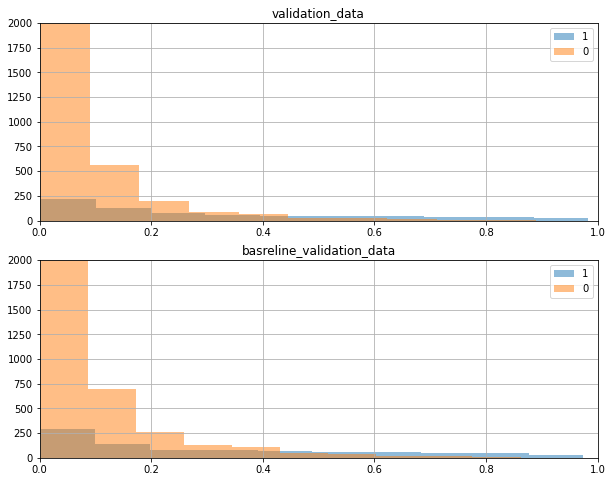

In [64]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))


fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

## チューニング

In [65]:
import optuna

In [66]:
# 探索するパラメータ

params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}
random_state=123

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves',8,256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',5,200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(x_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
        cat_cols = ['facility_id', 'icu_id']
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
    
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                  sample_weight = train_weight
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [68]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-31 11:38:56,782] A new study created in memory with name: no-name-3302300c-d6dc-4246-a08c-bba39dcda342


[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:39:31,131] Trial 0 finished with value: 0.8802157634485465 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'reg_alpha': 0.492522233779106, 'reg_lambda': 83.76388146302445}. Best is trial 0 with value: 0.8802157634485465.


[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessi

[I 2023-03-31 11:39:54,533] Trial 1 finished with value: 0.905313556776362 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'reg_alpha': 0.567922374174008, 'reg_lambda': 0.01732652966363563}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_i

[I 2023-03-31 11:40:13,233] Trial 2 finished with value: 0.8880039057277537 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'reg_alpha': 1.3406343673102123, 'reg_lambda': 3.4482904089131434}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006808799287054756
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-31 11:40:30,064] Trial 3 finished with value: 0.8853949700326522 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'reg_alpha': 0.2799978022399009, 'reg_lambda': 0.08185645330667264}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-31 11:40:46,600] Trial 4 finished with value: 0.8813062562616483 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'reg_alpha': 0.9434967110751797, 'reg_lambda': 0.5050346330980694}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004788147156768277
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-31 11:41:02,856] Trial 5 finished with value: 0.8775871632358476 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'reg_alpha': 3.1319282717196035, 'reg_lambda': 0.029005047452739414}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003971252247766701
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-31 11:41:35,360] Trial 6 finished with value: 0.8315971764743277 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'reg_alpha': 87.54657140659076, 'reg_lambda': 1.1965765212602313}. Best is trial 1 with value: 0.905313556776362.


[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0030131614432849746
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:41:59,676] Trial 7 finished with value: 0.9072413043008805 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'reg_alpha': 0.23499322154972468, 'reg_lambda': 0.1646202117975735}. Best is trial 7 with value: 0.9072413043008805.


[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00423029374725911
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

[I 2023-03-31 11:42:21,072] Trial 8 finished with value: 0.8883934305983109 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'reg_alpha': 2.206714812711709, 'reg_lambda': 3.1594683442464033}. Best is trial 7 with value: 0.9072413043008805.


[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7765808030254076e-05
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hes

[I 2023-03-31 11:42:37,771] Trial 9 finished with value: 0.8787358943823567 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.7765808030254076e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'reg_alpha': 0.05982625838323253, 'reg_lambda': 1.9490717640641542}. Best is trial 7 with value: 0.9072413043008805.


[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0010167214653943027
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in

[I 2023-03-31 11:42:50,056] Trial 10 finished with value: 0.8446425419265047 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.0010167214653943027, 'feature_fraction': 0.5040305717020102, 'bagging_fraction': 0.9940542446575642, 'reg_alpha': 0.010612397212799423, 'reg_lambda': 0.1661409929489422}. Best is trial 7 with value: 0.9072413043008805.


[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643816257078462
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002546304993969339, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002546304993969339
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6893072883706839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893072883706839
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643816257078462
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002546304993969339, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:43:10,774] Trial 11 finished with value: 0.9064039601156815 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.0002546304993969339, 'feature_fraction': 0.6893072883706839, 'bagging_fraction': 0.5643816257078462, 'reg_alpha': 0.10108607276304732, 'reg_lambda': 0.010211649165953098}. Best is trial 7 with value: 0.9072413043008805.


[LightGBM] [Warning] bagging_fraction is set=0.5185013294978341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185013294978341
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002476659931929152, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002476659931929152
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8075869290984223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8075869290984223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5185013294978341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185013294978341
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002476659931929152, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:43:33,863] Trial 12 finished with value: 0.9130824955554278 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 0.0002476659931929152, 'feature_fraction': 0.8075869290984223, 'bagging_fraction': 0.5185013294978341, 'reg_alpha': 0.0773906510818966, 'reg_lambda': 0.010147052843937873}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5011429065537674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5011429065537674
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.009612045303932889, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.009612045303932889
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.8573873579760407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8573873579760407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5011429065537674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5011429065537674
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.009612045303932889, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-31 11:43:56,077] Trial 13 finished with value: 0.9093829760569371 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.009612045303932889, 'feature_fraction': 0.8573873579760407, 'bagging_fraction': 0.5011429065537674, 'reg_alpha': 0.04095314498003704, 'reg_lambda': 0.07336144223207781}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5379227843179024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5379227843179024
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.009985319678066162, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.009985319678066162
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.849399773530255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.849399773530255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5379227843179024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5379227843179024
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.009985319678066162, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_le

[I 2023-03-31 11:44:19,339] Trial 14 finished with value: 0.9096360534091149 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.009985319678066162, 'feature_fraction': 0.849399773530255, 'bagging_fraction': 0.5379227843179024, 'reg_alpha': 0.014003769426640373, 'reg_lambda': 0.04018008439016229}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5022100713098457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5022100713098457
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0009463146919637712, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0009463146919637712
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.9540367721568721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9540367721568721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5022100713098457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5022100713098457
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0009463146919637712, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:44:41,483] Trial 15 finished with value: 0.9039505298546413 and parameters: {'num_leaves': 246, 'min_data_in_leaf': 63, 'min_sum_hessian_in_leaf': 0.0009463146919637712, 'feature_fraction': 0.9540367721568721, 'bagging_fraction': 0.5022100713098457, 'reg_alpha': 0.015259459849763084, 'reg_lambda': 0.011123421230463316}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5747934457613562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5747934457613562
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00010972017999740114, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00010972017999740114
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.8069514706584292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069514706584292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5747934457613562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5747934457613562
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00010972017999740114, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

[I 2023-03-31 11:45:04,121] Trial 16 finished with value: 0.9084289171136717 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.00010972017999740114, 'feature_fraction': 0.8069514706584292, 'bagging_fraction': 0.5747934457613562, 'reg_alpha': 0.02189233680455044, 'reg_lambda': 0.03433559455816001}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5650232345446958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650232345446958
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00046984197553640305, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00046984197553640305
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.896816979332782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.896816979332782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5650232345446958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650232345446958
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00046984197553640305, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

[I 2023-03-31 11:45:24,509] Trial 17 finished with value: 0.9033275132912546 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 56, 'min_sum_hessian_in_leaf': 0.00046984197553640305, 'feature_fraction': 0.896816979332782, 'bagging_fraction': 0.5650232345446958, 'reg_alpha': 0.040176896112029986, 'reg_lambda': 0.03431165111076506}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.6400627216813282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6400627216813282
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0017365404682439843, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0017365404682439843
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] feature_fraction is set=0.823310995063415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.823310995063415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6400627216813282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6400627216813282
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0017365404682439843, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:45:42,352] Trial 18 finished with value: 0.8809557738068807 and parameters: {'num_leaves': 252, 'min_data_in_leaf': 192, 'min_sum_hessian_in_leaf': 0.0017365404682439843, 'feature_fraction': 0.823310995063415, 'bagging_fraction': 0.6400627216813282, 'reg_alpha': 0.011377932362839219, 'reg_lambda': 0.011888747970176899}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5301478952337736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5301478952337736
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003347569638275178, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0003347569638275178
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9141396351636366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9141396351636366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5301478952337736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5301478952337736
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003347569638275178, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:45:55,942] Trial 19 finished with value: 0.8482057898211713 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.0003347569638275178, 'feature_fraction': 0.9141396351636366, 'bagging_fraction': 0.5301478952337736, 'reg_alpha': 0.12426865952491957, 'reg_lambda': 0.04725200328500893}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.6051660400345745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6051660400345745
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0013845801360137025, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0013845801360137025
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.7448407759841482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7448407759841482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6051660400345745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6051660400345745
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0013845801360137025, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:46:17,584] Trial 20 finished with value: 0.9036779684489359 and parameters: {'num_leaves': 201, 'min_data_in_leaf': 73, 'min_sum_hessian_in_leaf': 0.0013845801360137025, 'feature_fraction': 0.7448407759841482, 'bagging_fraction': 0.6051660400345745, 'reg_alpha': 0.0338817711689095, 'reg_lambda': 0.16313592403494287}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5029383333769748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5029383333769748
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00942960558399262, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00942960558399262
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.8411930204343103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8411930204343103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5029383333769748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5029383333769748
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00942960558399262, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_lea

[I 2023-03-31 11:46:38,550] Trial 21 finished with value: 0.9073384637296943 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 0.00942960558399262, 'feature_fraction': 0.8411930204343103, 'bagging_fraction': 0.5029383333769748, 'reg_alpha': 0.03265144945207878, 'reg_lambda': 0.048904946790305374}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5355947838664834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5355947838664834
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.008997559274592146, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.008997559274592146
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.851708600585404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.851708600585404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5355947838664834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5355947838664834
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.008997559274592146, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_le

[I 2023-03-31 11:46:59,825] Trial 22 finished with value: 0.9090130990224246 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.008997559274592146, 'feature_fraction': 0.851708600585404, 'bagging_fraction': 0.5355947838664834, 'reg_alpha': 0.06866583912973664, 'reg_lambda': 0.020103397131227455}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5420254458036684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5420254458036684
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0019886465926284035, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0019886465926284035
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9366816593422714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9366816593422714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5420254458036684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5420254458036684
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0019886465926284035, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:47:26,064] Trial 23 finished with value: 0.9108821487125844 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.0019886465926284035, 'feature_fraction': 0.9366816593422714, 'bagging_fraction': 0.5420254458036684, 'reg_alpha': 0.02526327144383917, 'reg_lambda': 0.07814881073745218}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.604358812615023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604358812615023
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0020701557912364663, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0020701557912364663
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] feature_fraction is set=0.999975195218377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999975195218377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.604358812615023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604358812615023
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0020701557912364663, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

[I 2023-03-31 11:47:46,947] Trial 24 finished with value: 0.8918008439773772 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 111, 'min_sum_hessian_in_leaf': 0.0020701557912364663, 'feature_fraction': 0.999975195218377, 'bagging_fraction': 0.604358812615023, 'reg_alpha': 0.022187141780331904, 'reg_lambda': 0.022092286593398874}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5531994420722199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531994420722199
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006315689641858747, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006315689641858747
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9237476615252599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237476615252599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5531994420722199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531994420722199
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006315689641858747, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:48:08,299] Trial 25 finished with value: 0.8991219073311238 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 0.0006315689641858747, 'feature_fraction': 0.9237476615252599, 'bagging_fraction': 0.5531994420722199, 'reg_alpha': 0.010012500531856776, 'reg_lambda': 0.08206727518615367}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5942296985738218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5942296985738218
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0026051624463431025, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0026051624463431025
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.9333298285957177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9333298285957177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5942296985738218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5942296985738218
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0026051624463431025, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-31 11:48:34,551] Trial 26 finished with value: 0.9067155563546525 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 0.0026051624463431025, 'feature_fraction': 0.9333298285957177, 'bagging_fraction': 0.5942296985738218, 'reg_alpha': 0.02409607802136647, 'reg_lambda': 0.011071195399648126}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.6617516781743211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617516781743211
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0015502358352680531, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0015502358352680531
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.88959479382419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88959479382419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6617516781743211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617516781743211
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0015502358352680531, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

[I 2023-03-31 11:49:02,543] Trial 27 finished with value: 0.9094412689845168 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 76, 'min_sum_hessian_in_leaf': 0.0015502358352680531, 'feature_fraction': 0.88959479382419, 'bagging_fraction': 0.6617516781743211, 'reg_alpha': 0.10075063828196289, 'reg_lambda': 0.022698397108009326}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5371654282178815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5371654282178815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.005873034983497463, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.005873034983497463
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.7854276349472066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7854276349472066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5371654282178815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5371654282178815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.005873034983497463, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-31 11:49:21,708] Trial 28 finished with value: 0.902568225124044 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.005873034983497463, 'feature_fraction': 0.7854276349472066, 'bagging_fraction': 0.5371654282178815, 'reg_alpha': 0.04888859995026821, 'reg_lambda': 0.3493056602476094}. Best is trial 12 with value: 0.9130824955554278.


[LightGBM] [Warning] bagging_fraction is set=0.5807086914598201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807086914598201
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.005460890788456033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.005460890788456033
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.8260914995385596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8260914995385596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5807086914598201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807086914598201
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.005460890788456033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-31 11:49:46,431] Trial 29 finished with value: 0.9074941132317105 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 60, 'min_sum_hessian_in_leaf': 0.005460890788456033, 'feature_fraction': 0.8260914995385596, 'bagging_fraction': 0.5807086914598201, 'reg_alpha': 0.017951288376835316, 'reg_lambda': 0.05393112265673973}. Best is trial 12 with value: 0.9130824955554278.


In [69]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.9131


{'num_leaves': 255,
 'min_data_in_leaf': 18,
 'min_sum_hessian_in_leaf': 0.0002476659931929152,
 'feature_fraction': 0.8075869290984223,
 'bagging_fraction': 0.5185013294978341,
 'reg_alpha': 0.0773906510818966,
 'reg_lambda': 0.010147052843937873}

In [70]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 255,
 'min_data_in_leaf': 18,
 'min_sum_hessian_in_leaf': 0.0002476659931929152,
 'feature_fraction': 0.8075869290984223,
 'bagging_fraction': 0.5185013294978341,
 'reg_alpha': 0.0773906510818966,
 'reg_lambda': 0.010147052843937873,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}

{'num_leaves': 255,
 'min_data_in_leaf': 18,
 'min_sum_hessian_in_leaf': 0.0002476659931929152,
 'feature_fraction': 0.8075869290984223,
 'bagging_fraction': 0.5185013294978341,
 'reg_alpha': 0.0773906510818966,
 'reg_lambda': 0.010147052843937873,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}

best
personalid含み、sumglassなし、
cats = ['facility_id', 'icu_5', 'icu_id']
dis_name = ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma'] 
チューニング